<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#SARIMAX" data-toc-modified-id="SARIMAX-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>SARIMAX</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Lasso</a></span></li></ul></li><li><span><a href="#Тест" data-toc-modified-id="Тест-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тест</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
pip install optuna


     |████████████████████████████████| 409 kB 989 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import optuna
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

In [3]:
RANDOM_STATE = 12345

## Подготовка

In [4]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
data.sort_index(inplace=True)

In [6]:
data = data.resample('1H').sum()

In [7]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

In [8]:
data.index.is_monotonic

True

Отсортировали индекс. Теперь он монотонный. 

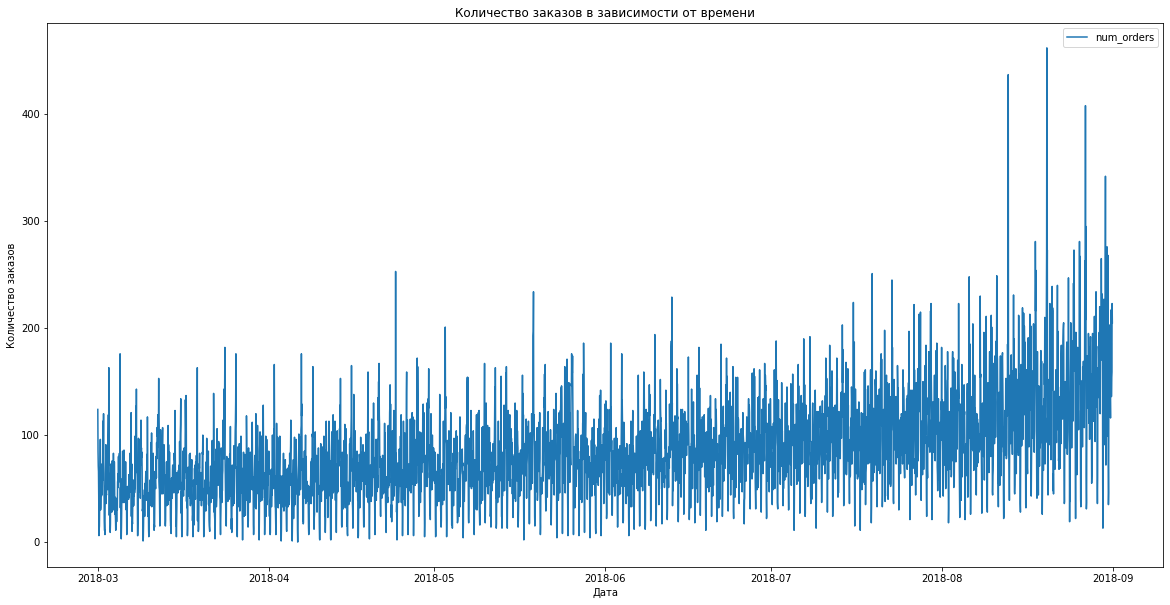

In [9]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=data)
plt.title('Количество заказов в зависимости от времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Данных достаточно мало, даже на таком графике видны всплески активности в некоторые дни.

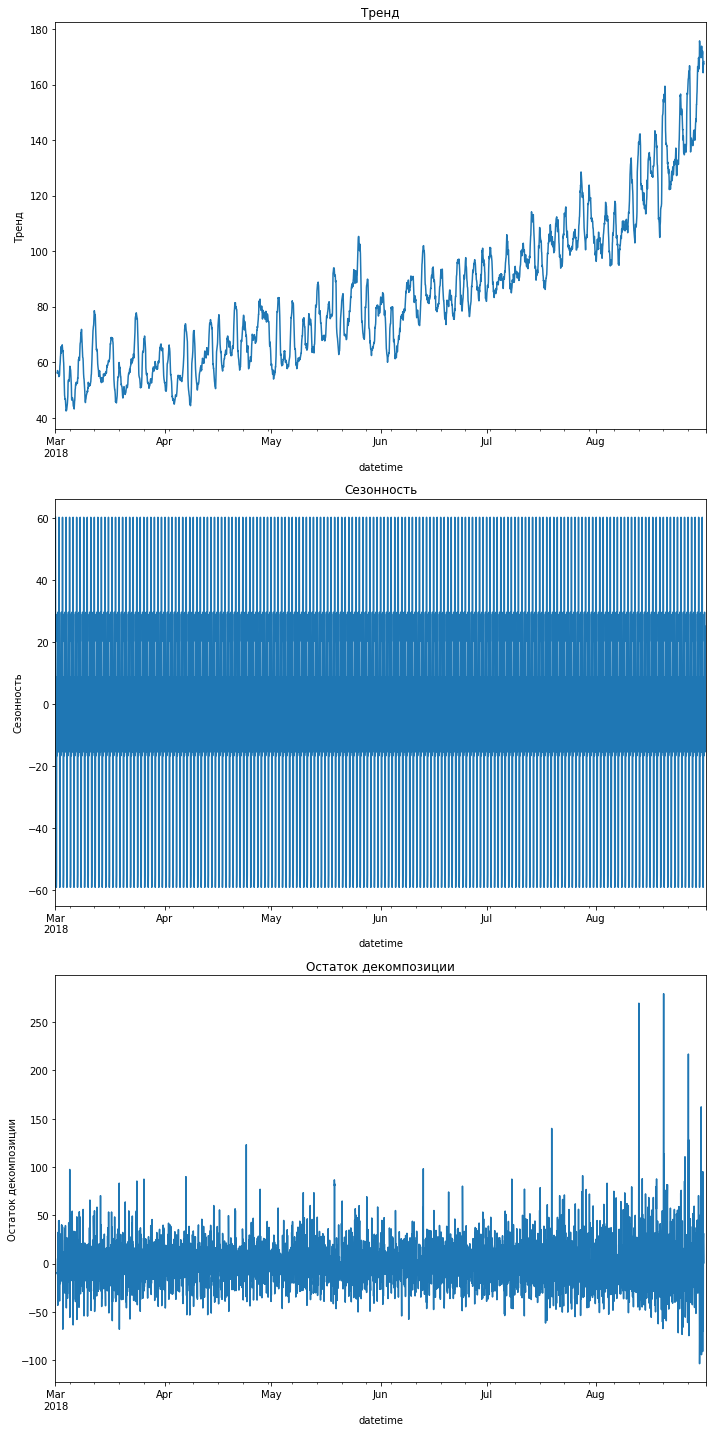

In [10]:
decomposed = sm.tsa.seasonal_decompose(data)

fig, axes = plt.subplots(3, 1, figsize=(10, 20))

decomposed.trend.plot(ax=axes[0], title='Тренд')
decomposed.seasonal.plot(ax=axes[1], title='Сезонность')
decomposed.resid.plot(ax=axes[2], title='Остаток декомпозиции')

axes[0].set_ylabel('Тренд')
axes[1].set_ylabel('Сезонность')
axes[2].set_ylabel('Остаток декомпозиции')

plt.tight_layout()
plt.show()


- Тренд <br>
На графике тренда видно увеличение кол-ва заказов такси. Пока большего сказать о тренде я не могу. 
- Сезонность <br>
График сезонности имеет одинаковую частоту и аплитуду, что показывает нам, что наши данные имеют стационарную сезонность, т.е. наши данные не меняются со временем. Но для такого вывода нам нужно было бы больше данных, чтоб оценивать сезонность. 
- Остаток <br>
На графике остатка декомпозиции присутствуют всплески с большой аплитудой с данными свежими. Вероятнее всего, это можно объяснить тем, что либо больше кол-во рейсов в аэропорт осуществляться начало (допустим, расширение терминала аэропорта), либо просто внимание директора компании стало более сосредоточенным, что влияет на проблему предсказания необходимого кол-ва машин (отсюда и аплитуда, есть отрицательные и положительные остатки )

Далее, я буду создавать признаки для модели.

## Создание признаков

Попробую сделать неделю для скользящего среднего и неделю для прыдыдущих значений. 
Если этого будет недостаточно, то в виде дополнительного перебора еще будут эти параметры. 

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [12]:
make_features(data, 2, 24)

In [13]:
data

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,168.041667


## Обучение

Наметим таргет и фичи, а также разделим выборки. Обязательным условием было - размер test_size = 0.1

In [14]:
target = data['num_orders']
feature = data.drop('num_orders', axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, 
                                                    test_size=0.2, random_state= RANDOM_STATE, shuffle= False)
X_val, X_val_test, y_val, y_val_test = train_test_split(X_test, y_test, test_size= 0.5, random_state= RANDOM_STATE, 
                                                       shuffle= False)

In [16]:
print(X_train.shape)
X_val.shape

(3532, 5)


(442, 5)

### CatBoost

In [17]:
def objective(trial, X_train, y_train,X, y_val):
    params = {
      "iterations": 1000,
      "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
      "depth": trial.suggest_int("depth", 1, 12),
      "subsample": trial.suggest_float("subsample", 0.05, 1.0),
      "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
      "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
  }
    model = cb.CatBoostRegressor(**params, silent=True, random_state= RANDOM_STATE)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=30)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2023-12-07 20:26:04,326] A new study created in memory with name: no-name-6aba883b-4947-46ad-8b44-63923fef97c5
[I 2023-12-07 20:26:06,019] Trial 0 finished with value: 41.15775599652583 and parameters: {'learning_rate': 0.0018803120993401, 'depth': 6, 'subsample': 0.567110839984639, 'colsample_bylevel': 0.5782882033084076, 'min_data_in_leaf': 44}. Best is trial 0 with value: 41.15775599652583.
[I 2023-12-07 20:26:07,625] Trial 1 finished with value: 40.48273901456818 and parameters: {'learning_rate': 0.0019157126691039844, 'depth': 6, 'subsample': 0.38651539650059064, 'colsample_bylevel': 0.8146333442412843, 'min_data_in_leaf': 60}. Best is trial 1 with value: 40.48273901456818.
[I 2023-12-07 20:26:12,426] Trial 2 finished with value: 38.82770122319357 and parameters: {'learning_rate': 0.002086206532753508, 'depth': 9, 'subsample': 0.42377579452715286, 'colsample_bylevel': 0.8859980866546114, 'min_data_in_leaf': 100}. Best is trial 2 with value: 38.82770122319357.
[I 2023-12-07 20:2

Best hyperparameters: {'learning_rate': 0.06685531382173267, 'depth': 6, 'subsample': 0.2532044215622801, 'colsample_bylevel': 0.6481027480682321, 'min_data_in_leaf': 3}
Best RMSE: 30.241157212732062


In [18]:
best_params_for_cb = study.best_trial.params

In [19]:
model = cb.CatBoostRegressor(iterations = 1000,
                             learning_rate = best_params_for_cb['learning_rate'],
                             depth = best_params_for_cb['depth'],
                             subsample = best_params_for_cb['subsample'],
                             colsample_bylevel = best_params_for_cb['colsample_bylevel'],
                             min_data_in_leaf = best_params_for_cb['min_data_in_leaf'], silent=True,
                            random_state = RANDOM_STATE)
cb_model = model.fit(X_train, y_train)
predictions = model.predict(X_val)
rmse_cb = mean_squared_error(y_val, predictions, squared=False)

In [20]:
rmse_cb

30.241157212732062

### SARIMAX

In [21]:
def objective(trial):
    model = SARIMAX(y_train,  random_state= RANDOM_STATE, 
                    order=(trial.suggest_int('p', 0, 2),
                                  trial.suggest_int('d', 0, 2),
                                  trial.suggest_int('q', 0, 2)), 
                seasonal_order=(trial.suggest_int('P', 0, 2),
                                trial.suggest_int('D', 0, 2),
                                trial.suggest_int('Q', 0, 2),
                                trial.suggest_categorical('s', [12, 4])))
    model_fit = model.fit(disp=False)
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_val)-1)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2023-12-07 20:27:15,229] A new study created in memory with name: no-name-85a50af8-5295-4d0e-83bf-deb8f0f89fd1
[I 2023-12-07 20:27:15,734] Trial 0 finished with value: 57931.78476538182 and parameters: {'p': 2, 'd': 1, 'q': 0, 'P': 0, 'D': 2, 'Q': 0, 's': 4}. Best is trial 0 with value: 57931.78476538182.
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
[I 2023-12-07 20:27:35,164] Trial 1 finished with value: 81.76024709983278 and parameters: {'p': 0, 'd': 1, 'q': 2, 'P': 0, 'D': 2, 'Q': 1, 's': 4}. Best is trial 1 with value: 81.76024709983278.
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
[I 2023-12-07 20:27:

Best hyperparameters: {'p': 2, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 2, 's': 12}
Best RMSE: 31.460257852702387


Такие гиперпараметры (безрассудно-рандомные) были выбраны специально, дабы посмотреть, какая метрика будет при неправильном анализе данных. 

In [22]:
study.best_trial.params

{'p': 2, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 2, 's': 12}

In [23]:
best_params_for_sarimax = study.best_trial.params

In [24]:
model = SARIMAX(y_train, random_state= RANDOM_STATE, 
                order=(best_params_for_sarimax['p'],
                best_params_for_sarimax['d'],
                best_params_for_sarimax['q']),
                seasonal_order=(
                best_params_for_sarimax['P'],
                best_params_for_sarimax['D'],
                best_params_for_sarimax['Q'],
                best_params_for_sarimax['s']))
model_fit = model.fit(disp=False)
y_pred = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_val)-1)
rmse_sarimax = mean_squared_error(y_val, y_pred, squared=False)
print(rmse_sarimax)

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


31.460257852702387


### Lasso

In [25]:

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

In [26]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    model = Lasso(fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]), 
               normalize=trial.suggest_categorical('normalize', [True, False]), 
               alpha=trial.suggest_float('alpha', 1e-3, 1e1))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)


[I 2023-12-07 21:11:08,522] A new study created in memory with name: no-name-6e1976e1-96e3-4e4e-a900-34c60d61c9eb
[I 2023-12-07 21:11:08,528] Trial 0 finished with value: 41.12546745813309 and parameters: {'fit_intercept': False, 'normalize': True, 'alpha': 7.899209049644749}. Best is trial 0 with value: 41.12546745813309.
[I 2023-12-07 21:11:08,536] Trial 1 finished with value: 41.21132700568858 and parameters: {'fit_intercept': False, 'normalize': False, 'alpha': 0.9383259145170204}. Best is trial 0 with value: 41.12546745813309.
[I 2023-12-07 21:11:08,618] Trial 2 finished with value: 41.22544964980263 and parameters: {'fit_intercept': True, 'normalize': False, 'alpha': 6.661492132348847}. Best is trial 0 with value: 41.12546745813309.
[I 2023-12-07 21:11:08,623] Trial 3 finished with value: 58.23418017859991 and parameters: {'fit_intercept': True, 'normalize': True, 'alpha': 4.423772873632967}. Best is trial 0 with value: 41.12546745813309.
[I 2023-12-07 21:11:08,717] Trial 4 finis

Best hyperparameters: {'fit_intercept': False, 'normalize': False, 'alpha': 9.999871048167206}
Best RMSE: 41.10309964948418


In [27]:
best_params_for_lasso = study.best_trial.params

In [28]:
model = Lasso(fit_intercept=best_params_for_lasso['fit_intercept'], 
               normalize=best_params_for_lasso['normalize'], 
               alpha=best_params_for_lasso['alpha'])
model.fit(X_train, y_train)
predictions = model.predict(X_val)
rmse_lasso = mean_squared_error(y_val, predictions, squared=False)

In [29]:
rmse_lasso

41.10309964948418

In [30]:
data = [rmse_cb, rmse_sarimax, rmse_lasso ]

In [31]:
scores = pd.DataFrame(data, columns= ['score'],
                      index= ['CatBoostRegressor', 'SARIMAX', 'Lasso'])
scores

,score
CatBoostRegressor,30.241157
SARIMAX,31.460258
Lasso,41.103100


Проверили три различных модели, одна из которых для меня была абсолютно новой. <br>
Она же и оказалась самой точной, набрала лучшую метрику. <br>
Порог метрики, важной заказчику, мы преодолели. <br>

## Тест

### CatBoost

In [33]:
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)


In [34]:
model = cb.CatBoostRegressor(iterations = 1000,
                             learning_rate = best_params_for_cb['learning_rate'],
                             depth = best_params_for_cb['depth'],
                             subsample = best_params_for_cb['subsample'],
                             colsample_bylevel = best_params_for_cb['colsample_bylevel'],
                             min_data_in_leaf = best_params_for_cb['min_data_in_leaf'], silent=True,
                            random_state = RANDOM_STATE)
model.fit(X_train_val, y_train_val)

In [35]:
preds = model.predict(X_val_test)
rmse_best_model_on_valtest = mean_squared_error(y_val_test, preds, squared=False)

print('RMSE best-model on val-test:', rmse_best_model_on_valtest)

RMSE best-model on val-test: 46.46691078867796
